# PROYEK KLASIFIKASI GAMBAR
### Image Classification Model Deployment
Disusun Oleh: Muchammad Malik

Notes:
1. Dataset diambil dari Kaggle, pada tanggal 15 Juli 2021, dengan link: https://www.kaggle.com/ashishsaxena2209/animal-image-datasetdog-cat-and-panda
2. Untuk load dataset langsung dari runtime, input username dan password akun Kaggle
3. Akurasi terbesar pada percobaan terakhir adalah 0.9351 untuk data training dan 0.9267 untuk data validasi
 

In [1]:
import os
os.environ['KAGGLE_USERNAME'] = #INPUT USERNAME
os.environ['KAGGLE_KEY'] = #INPUT PASSWORD

!kaggle datasets download -d ashishsaxena2209/animal-image-datasetdog-cat-and-panda

100% 375M/376M [00:12<00:00, 39.0MB/s]
100% 376M/376M [00:12<00:00, 32.2MB/s]


In [2]:
!unzip -q animal-image-datasetdog-cat-and-panda.zip -d .

In [3]:
os.listdir('/content/animals')

['animals', 'dogs', 'images', 'cats', 'panda']

In [4]:
os.listdir('/content/animals/animals')

['dogs', 'cats', 'panda']

In [5]:
#Pengecekan jumlah file
print('cats:', len(os.listdir('/content/animals/animals/cats')))
print('dogs:',len(os.listdir('/content/animals/animals/dogs')))
print('panda:',len(os.listdir('/content/animals/animals/panda')))

cats: 1000
dogs: 1000
panda: 1000


In [6]:
base_dir= '/content/animals/animals/'

In [7]:
#pemisahan file menjadi training file dan validation file
!pip install split-folders tqdm #instalasi splitfolder

import splitfolders
base_dir = '/content/animals/animals/' 
splitfolders.ratio(base_dir, output=base_dir, ratio=(.8, .2))

Copying files: 3000 files [00:00, 3029.62 files/s]


In [8]:
os.listdir('/content/animals/animals/')

['train', 'dogs', 'cats', 'panda', 'val']

In [9]:
os.listdir('/content/animals/animals/train')
os.listdir('/content/animals/animals/val')

['dogs', 'cats', 'panda']

In [10]:
#Pengecekan Jumlah data training dan validation
train_panda = os.listdir('/content/animals/animals/train/panda')
train_cats = os.listdir('/content/animals/animals/train/cats')
train_dogs = os.listdir('/content/animals/animals/train/dogs')
val_panda = os.listdir('/content/animals/animals/val/panda')
val_cats = os.listdir('/content/animals/animals/val/cats')
val_dogs = os.listdir('/content/animals/animals/val/dogs')

print('Jumlah data training panda:', len(train_panda))
print('Jumlah data training cats:', len(train_cats))
print('Jumlah data training dogs:', len(train_dogs))
print('Jumlah data validation panda:', len(val_panda))
print('Jumlah data validation cats:', len(val_cats))
print('Jumlah data validation dogs:', len(val_dogs))

Jumlah data training panda: 800
Jumlah data training cats: 800
Jumlah data training dogs: 800
Jumlah data validation panda: 200
Jumlah data validation cats: 200
Jumlah data validation dogs: 200


In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
data_training_generator = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

data_testing_generator = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

In [13]:
#inisiasi variabel data training dan data testing
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'val')

In [14]:
training_generator = data_training_generator.flow_from_directory(
        train_dir,  # direktori data training
        target_size=(100, 100),  # mengubah resolusi seluruh gambar menjadi 150x150 piksel
        batch_size=9,
        class_mode='categorical')

testing_generator = data_testing_generator.flow_from_directory(
        test_dir, # direktori data testing
        target_size=(100, 100), # mengubah resolusi seluruh gambar menjadi 150x150 piksel
        batch_size=9, 
        class_mode='categorical')

#direktori kelas
training_generator.class_indices

Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


{'cats': 0, 'dogs': 1, 'panda': 2}

In [19]:
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import ResNet152V2

#Penyusunan arsitektur neural network menggunakan transfer learning model ResNet152V2
model = tf.keras.models.Sequential([
    ResNet152V2(weights="imagenet", include_top=False, input_tensor=Input(shape=(100, 100, 3))),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    #tf.keras.layers.Dropout(0.3), 
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(3, activation='softmax', name='class_output') 
      #fungsi aktivasi softmax cocok untuk data yang jumlah kelasnya lebih dari 2
])
model.layers[0].trainable = False

#ilustrasi model
model.summary()

#Pemilihan loss, optimizer, dan metrics
model.compile(loss='categorical_crossentropy', #data bersifat multiclass
              optimizer='adam',
              metrics=['accuracy'])

#menghentikan training ketika akurasi mencapai 92% dengan callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.92 and logs.get('val_accuracy')>0.92):
      print("\nAkurasi Training dan validasi telah mencapai >92%!")
      self.model.stop_training = True

history = model.fit(
      training_generator, #menampilkan akurasi data training
      steps_per_epoch=50,  # jumlah steps tiap epoch data training
      epochs=100, #jumlah epoch keseluruhan
      validation_data=testing_generator, # menampilkan akurasi data testing
      validation_steps=50,  
      verbose=1, #verbose bernilai 1 untuk menambah animasi loading 
      callbacks = myCallback()
      )

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 4, 4, 2048)        58331648  
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 2, 64)          1179712   
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               33280     
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
class_output (Dense)         (None, 3)                

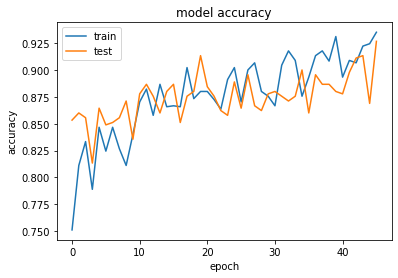

In [24]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

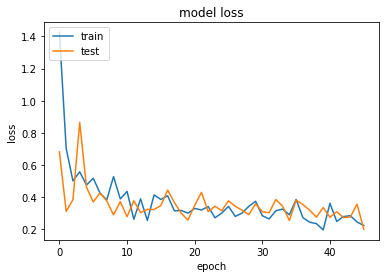

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [26]:
model

In [27]:
# Konversi model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tmp/tmp66f40mi9/assets


In [28]:
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)